In [40]:
##intial imports and magics
import sys
import os

%matplotlib inline
#import matplotlib
# Force matplotlib to not use any Xwindows backend.
#matplotlib.use('Agg')

#from scipy.optimize import minimize
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import statsmodels.api as sm

#plt.style.use('ggplot')

In [2]:
##rpy and required packages
%load_ext rpy2.ipython
#custom modules
import rpy2.robjects as robjects
#if forecast_rpy: del sys.modules['forecast_rpy']
import r_holtwinters_forecast

In [14]:
### SET GA AND PROJECT SPECIFIC VARIABLES
profile_number = 'ga:1234567'

end_date = '2016-05-01'
client_name = 'tbc'

In [29]:
##read data from DB
from config import Config

config = Config()
db_connector = 'mysql://%s:%s@localhost/%s' % (config.DB_USER, config.DB_PSW,config.DB_NAME)
df = pd.read_sql(config.DB_GA_TABLE,db_connector)
df.head(n=2)
start_date = df.date.min().strftime('%Y-%m-%d') #'2015-06-01'

In [32]:
#put GA data into dataframe
#df = pd.DataFrame(rows,columns=heads)
#convert sessions column to numeric format
#df['ga:sessions'] = df['ga:sessions'].convert_objects(convert_numeric=True)

#create list for R usage
historic_sessions = df['sessions'].tolist()
historic_revenue = df['revenue'].astype('float').tolist()

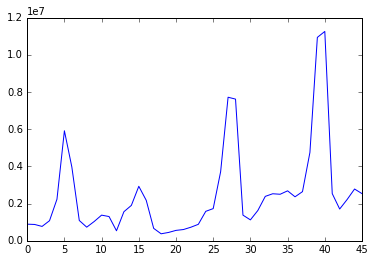

In [44]:
plt.plot(historic_revenue)

### Assessing Data Components

#### Autocorrelation
Non-random data displays ac's close to zero, wheareas seasonaly predictable data should show spikes at even intervals (e.g once every 12 months)

### Decomposition
This should clearly show consistent seasonality, and also gives an idea of growth/shrinking overtime



In [33]:
from pandas.tools.plotting import autocorrelation_plot
#plt.figure()

#plot autocorrelations
autocorrelation_plot(historic_sessions)

#create range and plot time series components
rng = pd.date_range(start_date,end_date,freq='MS')
dta = pd.Series(historic_sessions,index=rng)

#decompose historic data and plot 
#res = sm.tsa.seasonal_decompose(dta)
#resplot = res.plot()

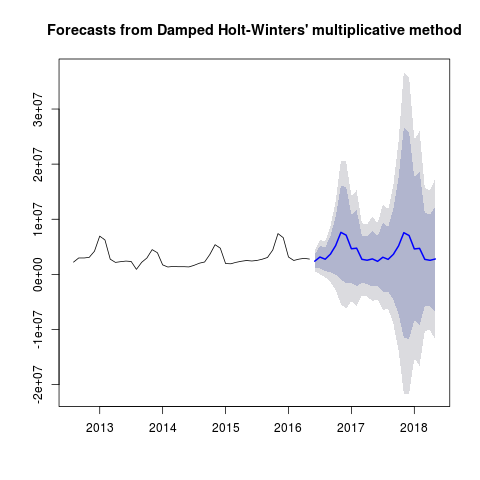

Mean Absolute Percentage Error: 23.9221383778


In [34]:
"""Forecast Sessions"""
#run data through forecast function and convert back to R object
results = r_holtwinters_forecast.main(historic_sessions,start_date)
fcast = results[0]
%Rpush fcast
%Rpush historic_sessions

#plot the results
%R plot(fcast)
print 'Mean Absolute Percentage Error: %s'% results[1][4]

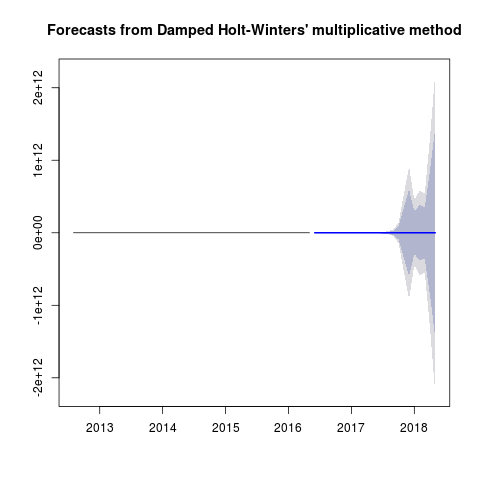

Mean Absolute Percentage Error: 32.5809440987


In [57]:
"""Forecast Revenue"""
#run data through forecast function and convert back to R object
results = r_holtwinters_forecast.main(historic_revenue,start_date)
rev_fcast = results[0]
%Rpush rev_fcast
%Rpush historic_revenue

#plot the results
%R plot(rev_fcast)
print 'Mean Absolute Percentage Error: %s'% results[1][4]

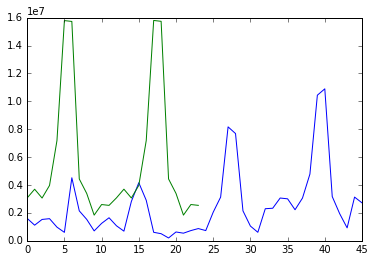

In [64]:
fig = plt.figure()
plt.plot(rev_fcast[6])
plt.plot(rev_fcast[1])
plt.show()

In [90]:
'''Extract forecast data and tidy into single data frame'''

#create date range for index
dates = pd.date_range(pd.to_datetime(end_date) +  pd.DateOffset(days=0) +  pd.DateOffset(months=0, days=1), periods=24, freq='MS')

#extract session data from R object
sessions_mean = pd.DataFrame(np.asarray(fcast[1]),columns=['sessions'],index=dates)
session_conf_lower = pd.DataFrame(np.asarray(fcast[5]),columns=['lower80','lower95'],index=dates)
session_conf_upper = pd.DataFrame(np.asarray(fcast[4]),columns=['upper80','upper95'],index=dates)

#extract revenue data from R object
rev_mean = pd.DataFrame(np.asarray(rev_fcast[1]),columns=['transactionRevenue'],index=dates)
rev_conf_lower = pd.DataFrame(np.asarray(rev_fcast[5]),columns=['lower80','lower95'],index=dates)
rev_conf_upper = pd.DataFrame(np.asarray(rev_fcast[4]),columns=['upper80','upper95'],index=dates)

#concatenated sessions and revenue into a single dataframe
forecast_data = pd.concat([sessions_mean,session_conf_lower['lower80'],session_conf_upper['upper80'],rev_mean,rev_conf_lower['lower80'],rev_conf_upper['upper80']], axis=1)

In [97]:
'''Output files to relevant directory'''
results_path = '/home/queryclick/apps/radge/data/forecasts'

#save forecast data
save_url = results_path + '/fcast_%s.csv' % client_name
forecast_data.to_csv(save_url)

#save historic data
historic_url = results_path + '/fcast_%s_historic.csv' % client_name
df.to_csv(historic_url)
